In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential,Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import cv2
import tensorflow as tf
import keras
from keras import layers,models

Using TensorFlow backend.


In [0]:
from google.colab import drive

drive.mount('/gdrive')
%cd '/gdrive/My Drive/EVA2_2019/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/EVA2_2019


In [0]:
# %cd vision_utils_data_science/utils
# %cd ../../

/


In [0]:
!ls 

bin	 datalab  home	 lib64	opt   run   swift	      tmp    var
boot	 dev	  lib	 media	proc  sbin  sys		      tools
content  etc	  lib32  mnt	root  srv   tensorflow-2.0.0  usr


In [0]:
# !rm -rf vision_utils_data_science/

In [0]:
!git pull origin master

From https://github.com/shaikkamran/vision_utils_data_science
 * branch            master     -> FETCH_HEAD
Already up to date.


In [2]:
!git clone https://github.com/shaikkamran/vision_utils_data_science.git

Cloning into 'vision_utils_data_science'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 10), reused 39 (delta 9), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [3]:
%cd vision_utils_data_science/utils

/content/vision_utils_data_science/utils


In [0]:
from visualization import display_images_per_class 

In [0]:
from img_data import ImgData


In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train=x_train/255
x_test=x_test/255
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

# train_mean = np.mean(x_train, axis=(0,1,2))
# train_std = np.std(x_train, axis=(0,1,2))
train_mean = np.array([0.4914,0.4822,0.4465])
train_std = np.array([0.2023,0.1994,0.2010])

def pad_img(img):
  return np.pad(img, ((4,4),(4,4),(0,0)), mode='constant',)
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
# pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

# x_train=pad4(normalize(x_train))

In [0]:
denormalize = lambda x,mean,std: (((x*std)+mean)*255).astype('uint8')

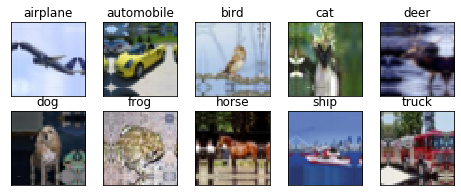

In [35]:
display_images_per_class(class_names=class_names)(ImgData(denormalize(x_train,train_mean,train_std),y_train))

In [0]:
def random_crop(x, random_crop_size):
    w, h = x.shape[0], x.shape[1]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1],:]

In [0]:
x_train_rd_crop=np.array([random_crop(i,(32,32)) for i in x_train])

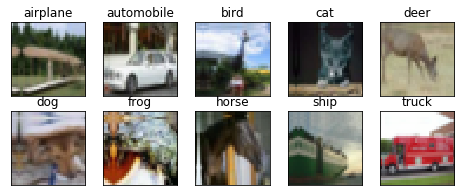

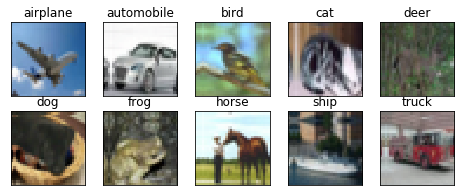

In [52]:
display_images_per_class(class_names=class_names,no_times=2)(ImgData(denormalize(x_train_rd_crop,train_mean,train_std),y_train))

In [0]:
x_test=normalize(x_test)

In [0]:
from tranforms import get_cutout_eraser

In [0]:
x_train_cut_out=np.array([get_cutout_eraser()(x) for x in x_train_rd_crop])

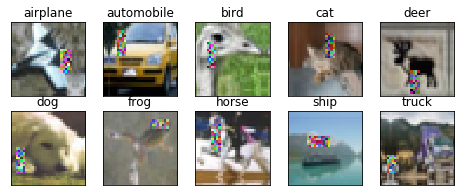

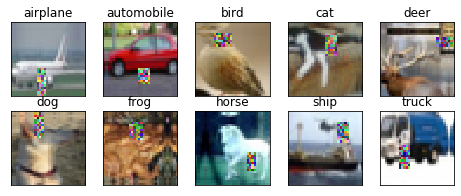

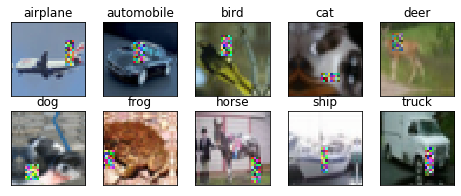

In [42]:
display_images_per_class(class_names=class_names,no_times=3)(ImgData(denormalize(x_train_cut_out,train_mean,train_std),y_train))

In [88]:
x_train.shape

(50000, 40, 40, 3)

In [0]:
cut_out=get_cutout_eraser()
def preprocess(x):
  # x=pad4(x)
  x=pad_img(x)
  x=random_crop(x,[32,32])
  x=cut_out(x)
  return x

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
import collections

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    CHANNEL_AXIS=3
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    # if K.image_dim_ordering() == 'tf':
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    # else:
    #     CHANNEL_AXIS = 1
    #     ROW_AXIS = 2
    #     COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        # if K.image_dim_ordering() == 'tf':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        # block_fn = _get_block(block_fn)
        block_fn=basic_block

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(1, 1))(input)
        # pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = conv1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_13(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2])
    
    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [0]:
model=ResnetBuilder.build_resnet_13((3,32,32),10)

In [0]:
from keras.regularizers import l2
from keras.layers import *

In [0]:
import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

def min_max_scaler(iterations, num_iterations, end_percentage, min_val, max_val, invert = False, triangle_tilt = 0.75):
  non_slant_mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
  mid_cycle_id = int(triangle_tilt*int(num_iterations * ((1. - end_percentage)) / float(2)))
  value = 0
  if iterations > 2 * non_slant_mid_cycle_id:
    
    
      extra_iters = (iterations - 2 * non_slant_mid_cycle_id)
      current_percentage = 1 - (1 - 1/10)*extra_iters/(num_iterations - 2 * non_slant_mid_cycle_id)
            

  elif iterations >  mid_cycle_id:
      current_percentage = 1. - (iterations - mid_cycle_id) / (2*non_slant_mid_cycle_id - mid_cycle_id)
      
  else:
      current_percentage = iterations / mid_cycle_id
      
  if invert:
    if iterations > 2 * non_slant_mid_cycle_id:
      return max_val
    return max_val - current_percentage * (max_val - min_val)
  else:
    if iterations > 2 * non_slant_mid_cycle_id:
      return min_val * current_percentage
    return min_val + current_percentage * (max_val - min_val)
  
# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 triangle_tilt = 0.75,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        new_lr = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.initial_lr/self.scale, self.initial_lr, invert = False, triangle_tilt=triangle_tilt)
        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """    
        new_momentum = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.min_momentum, self.max_momentum, invert = True, triangle_tilt=triangle_tilt)
        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))
                
    
    def plot(self):
        plt.title("LR-Plot")
        plt.plot(self.history['lr'])
        plt.xlabel("Epochs")
        plt.ylabel("LR")
        plt.show()
        
        plt.title("Momentum-Plot")
        plt.plot(self.history['momentum'])
        plt.xlabel("Epochs")
        plt.ylabel("Momentum")
        plt.show()



In [0]:
from keras.optimizers import *
sgd=SGD(lr=0.01,momentum=0.9)

In [0]:
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [49]:
x_train.shape

(50000, 40, 40, 3)

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, featurewise_center=False,featurewise_std_normalization=False,
                             horizontal_flip=True,preprocessing_function=preprocess)


In [0]:
datagen.fit(x_train)

In [0]:
train_iterator = datagen.flow(x_train, Y_train, batch_size=128,shuffle=True)

In [0]:
_=next(train_iterator)

In [0]:
one_cycle_lr=  OneCycleLR(epochs=30, batch_size = 256,steps=len(train_iterator), 
                 samples=x_train.shape[0], max_lr=0.5, verbose = True, scale = 50, end_percentage=0.1,
                 maximum_momentum = 0.9, minimum_momentum=0.8)


In [0]:

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False)
datagen_validation.fit(x_test)
# checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


# train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(x_test, Y_test, batch_size=128,shuffle=True)


In [81]:
x_train.shape

(50000, 32, 32, 3)

In [96]:
preprocess(x_train[0]).shape

(32, 32, 3)

Epoch 1/30
  5/391 [..............................] - ETA: 3:08 - loss: 0.3623 - acc: 0.9563

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


391/391 [==============================] - 28s 72ms/step - loss: 0.3576 - acc: 0.9480 - val_loss: 2.7437 - val_acc: 0.3921
 - lr: 0.05023 - momentum: 0.89 
Epoch 2/30
391/391 [==============================] - 26s 66ms/step - loss: 0.4826 - acc: 0.9060 - val_loss: 2.2092 - val_acc: 0.5794
 - lr: 0.09057 - momentum: 0.88 
Epoch 3/30
391/391 [==============================] - 26s 67ms/step - loss: 0.5496 - acc: 0.8881 - val_loss: 2.1391 - val_acc: 0.5638
 - lr: 0.13090 - momentum: 0.88 
Epoch 4/30
391/391 [==============================] - 26s 67ms/step - loss: 0.5952 - acc: 0.8800 - val_loss: 0.9505 - val_acc: 0.7798
 - lr: 0.17124 - momentum: 0.87 
Epoch 5/30
391/391 [==============================] - 27s 68ms/step - loss: 0.6269 - acc: 0.8786 - val_loss: 1.1952 - val_acc: 0.7275
 - lr: 0.21157 - momentum: 0.86 
Epoch 6/30
391/391 [==============================] - 26s 67ms/step - loss: 0.6516 - acc: 0.8725 - val_loss: 1.3851 - val_acc: 0.7161
 - lr: 0.25191 - momentum: 0.85 
Epoch 7/3

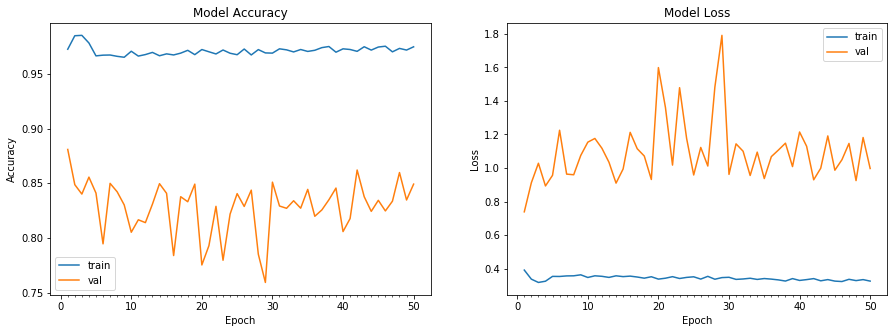

Accuracy on test data is: 93.44


In [119]:
from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(zoom_range=0.0, featurewise_center=False,featurewise_std_normalization=False,
#                              horizontal_flip=True,preprocessing_function=preprocess)


# train the model
start = time.time()
# Train the model
# model_info = model.fit_generator(datagen.flow(x_train, Y_train, batch_size = 128),
#                                  samples_per_epoch = x_train.shape[0], nb_epoch = 30, 
#                                  validation_data = (x_test, Y_test), verbose=1)
end_percentage = 0.05
triangle_tilt = 0.9

train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=30,callbacks=[one_cycle_lr])


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(x_test, Y_test, model))

Epoch 1/60
391/391 [==============================] - 26s 66ms/step - loss: 0.6735 - acc: 0.8506 - val_loss: 0.9885 - val_acc: 0.7501
Epoch 2/60
391/391 [==============================] - 26s 65ms/step - loss: 0.6572 - acc: 0.8559 - val_loss: 1.0155 - val_acc: 0.7361
Epoch 3/60
391/391 [==============================] - 25s 65ms/step - loss: 0.6464 - acc: 0.8591 - val_loss: 0.8271 - val_acc: 0.7951
Epoch 4/60
391/391 [==============================] - 26s 65ms/step - loss: 0.6323 - acc: 0.8630 - val_loss: 1.0154 - val_acc: 0.7551
Epoch 5/60
391/391 [==============================] - 26s 66ms/step - loss: 0.6230 - acc: 0.8670 - val_loss: 0.7962 - val_acc: 0.8090
Epoch 6/60
391/391 [==============================] - 26s 66ms/step - loss: 0.6100 - acc: 0.8720 - val_loss: 0.7946 - val_acc: 0.8146
Epoch 7/60
391/391 [==============================] - 26s 66ms/step - loss: 0.5988 - acc: 0.8763 - val_loss: 1.2565 - val_acc: 0.7059
Epoch 8/60
391/391 [==============================] - 25s 65ms

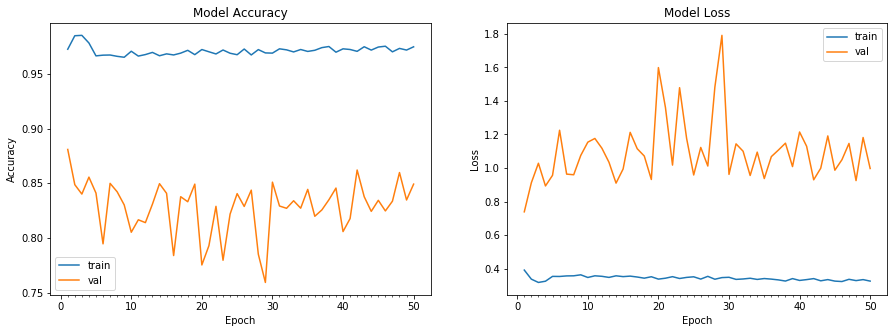

Accuracy on test data is: 86.07


In [99]:


train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=60)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(x_test, Y_test, model))

Epoch 1/60
391/391 [==============================] - 26s 67ms/step - loss: 0.4167 - acc: 0.9323 - val_loss: 1.0705 - val_acc: 0.7750
Epoch 2/60
391/391 [==============================] - 26s 66ms/step - loss: 0.4211 - acc: 0.9316 - val_loss: 0.9700 - val_acc: 0.7991
Epoch 3/60
391/391 [==============================] - 26s 66ms/step - loss: 0.4182 - acc: 0.9316 - val_loss: 0.6791 - val_acc: 0.8578
Epoch 4/60
391/391 [==============================] - 26s 66ms/step - loss: 0.4195 - acc: 0.9326 - val_loss: 0.6765 - val_acc: 0.8627
Epoch 5/60
391/391 [==============================] - 26s 66ms/step - loss: 0.4162 - acc: 0.9333 - val_loss: 0.8171 - val_acc: 0.8301
Epoch 6/60
391/391 [==============================] - 26s 66ms/step - loss: 0.4144 - acc: 0.9332 - val_loss: 0.8622 - val_acc: 0.8258
Epoch 7/60
391/391 [==============================] - 26s 66ms/step - loss: 0.4159 - acc: 0.9336 - val_loss: 0.6768 - val_acc: 0.8525
Epoch 8/60
391/391 [==============================] - 26s 66ms

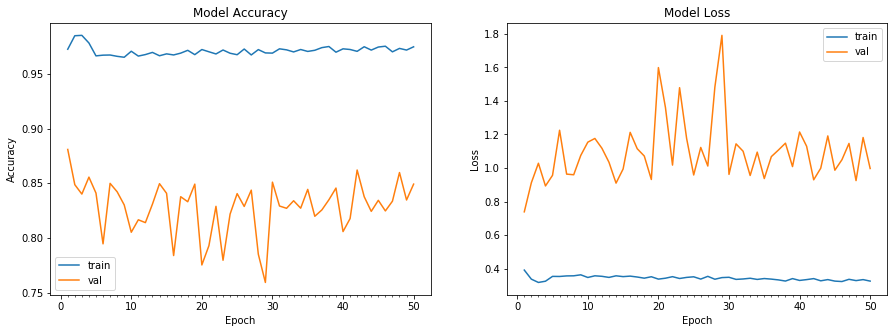

Accuracy on test data is: 87.54


In [101]:


train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=60)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(x_test, Y_test, model))

In [0]:
ly_train

(50000,)